In [86]:
import pandas as pd
import os, bz2, json, time
from datetime import timedelta
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import zipfile
import numpy as np

In [458]:
codes = ['CA', 'GB', 'US']
# codes=['CA']
columns = ['video_id', 'title', 'channelTitle',
       'categoryId', 'trending_date', 'tags', 'view_count', 'description']
df = pd.DataFrame(columns=columns)

with zipfile.ZipFile('archive.zip', 'r') as zf:
    for file in zf.namelist():
        if not (file[:2] in codes and file.endswith('.csv')):
#         if not file.endswith('.csv'):
            continue
        df = pd.concat([df, pd.read_csv(archive.open(file))[columns]], ignore_index=True)

In [459]:
data = df.drop_duplicates('video_id', keep='last').sort_values('video_id').reset_index(drop=True)
data

,video_id,title,channelTitle,categoryId,trending_date,tags,view_count,description
0,--0bCF-iK2E,Jadon Sancho • Magical Skills & Goals,Bundesliga,17,2021-07-08T00:00:00Z,football|soccer|fútbol alemán|Bundesliga|seaso...,433340,Enjoy the best skills and goals from Jadon San...
1,--14w5SOEUs,Migos - Avalanche (Official Video),MigosVEVO,10,2021-06-15T00:00:00Z,Migos|Avalanche|Quality|Control|Music/Motown|R...,6823249,Watch the the official video for Migos - Avala...
2,--2O86Z0hsM,MY TESLA PAYS FOR ITSELF,jf.okay,24,2022-03-15T00:00:00Z,[None],538485,NaN
3,--40TEbZ9Is,Supporting Actress in a Comedy: 73rd Emmys,Television Academy,24,2021-09-25T00:00:00Z,[None],682609,Hannah Waddingham wins the Emmy for Supporting...
4,--DKkzWVh-E,Why Retaining Walls Collapse,Practical Engineering,27,2021-12-11T00:00:00Z,retaining wall|New Jersey highway|Direct Conne...,623949,One of the most important (and innocuous) part...
...,...,...,...,...,...,...,...,...
40112,zzYaFc8nzQM,"The Champions: Season 4, Episode 4",B/R Football,17,2020-12-05T00:00:00Z,br football|bleacher report|soccer|football|go...,1046055,Dejan Lovren is convinced Virgil van Dijk is h...
40113,zzd4ydafGR0,Lil Tjay - Calling My Phone (feat. 6LACK) [Off...,Lil Tjay,10,2021-02-21T00:00:00Z,Lil Tjay|Steady Calling My Phone|Calling My Ph...,13974461,Official audio for Calling My Phone by Lil Tja...
40114,zziBybeSAtw,PELICANS at LAKERS | FULL GAME HIGHLIGHTS | Ja...,NBA,17,2021-01-18T00:00:00Z,NBA|G League|Basketball|game-0022000187|Lakers...,2598512,PELICANS at LAKERS | FULL GAME HIGHLIGHTS | Ja...
40115,zzk09ESX7e0,[MV] 마마무 (MAMAMOO) - Where Are We Now,MAMAMOO,10,2021-06-09T00:00:00Z,MAMAMOO|마마무|WAW|마마무 WAW|MAMAMOO WAW|Where Are ...,9389223,[MV] 마마무 (MAMAMOO) - Where Are We Now\r\rInsta...


In [462]:
data.loc[16, 'description']

'TURN ON THE BELL NOTIFICATION TO STAY UPDATED!SUBSCRIBE TO MY CHANNEL FOR MORE VIDEOS!FOLLOW ME ON SOCIAL MEDIA AND I WILL LOVE U!!!——————————————————————————————Twitter - http://twitter.com/VuJaeOfficialInstagram - https://www.instagram.com/VuJaeSnapchat - VuJaeFacebook - https://www.facebook.com/VuJaeOfficial/——————————————————————————————If you are reading this, I LOVE YOU! #VJGANG'

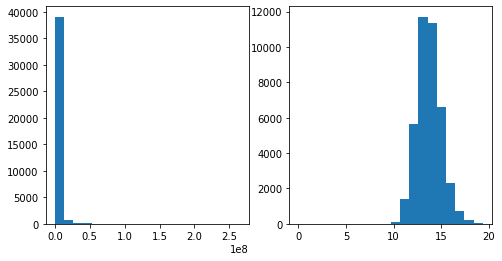

In [460]:
data['Log1pViews'] = np.log1p(data['view_count'].astype('int32')).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["view_count"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pViews'], bins=20);

In [461]:
replacer = dict()

with open('category-codes.txt') as f:
    categories = f.read().splitlines()
    for cat in categories:
        replacer[int(cat.split(' - ')[0])] = cat.split(' - ')[1]

In [468]:
import re

def get_link(stroka):
    return re.sub(r'https\S+', '', stroka)
    
get_link(' https://www.instagram.com/VuJaeSnapchat lol kek - VuJaeFacebook')

'  lol kek - VuJaeFacebook'

In [479]:
data['description'] = data['description'].str.replace(r'https\S+', 'link')
data.iloc[25703]

video_id                                               cs8EzU-OVSE
title                    What You Didn't Know About The Sidemen...
channelTitle                                            Miniminter
categoryId                                           Entertainment
trending_date                                 2021-11-30T00:00:00Z
tags             simon, sidemen, miniminter, mm7games, random, ...
view_count                                                  956377
description      Kon: link Subreddit: link you have an idea you...
Log1pViews                                                 13.7709
Name: 25703, dtype: object

In [481]:
text_columns = ['title', 'description', 'tags']
# text_columns = ['title', 'description']
categorical_columns = ['categoryId']
TARGET_COLUMN = "Log1pViews"

data[categorical_columns] = data[categorical_columns].replace(replacer).fillna('NaN')
data['title'] = data['title'].fillna('NaN')
data['description'] = data['description'].str.replace(r'https\S+', 'link').fillna('NaN')
data['tags'] = data['tags'].str.replace('|', ', ').replace('[None]', 'NaN')

data.sample(3)

,video_id,title,channelTitle,categoryId,trending_date,tags,view_count,description,Log1pViews
19371,Te236EDr_-k,Sanremo 2022 - Mahmood & Blanco cantano ‘Brividi’,Rai,Entertainment,2022-02-07T00:00:00Z,"Sanremo 2022, prima serata, Mahmood, Blanco, F...",8352732,link - Mahmood & Blanco cantano sul palco dell...,15.938099
32347,nNrg4TAOavI,Minecraft Fort...,Dream Shorts,People & Blogs,2021-04-09T00:00:00Z,NaN,2003743,Minecraft Fort...#shortsSUBSCRIBE! Lots of upl...,14.510528
32960,oO5Xu4hhthw,Klombo Saved Me From Bully🤭 #shorts,VMant,Gaming,2022-01-31T00:00:00Z,"vmant, fortnite, klombo, fortnite short, saved...",7225838,Klombo Saved Me From Toxic Bully Short,15.793174


In [482]:
print("Raw text:")
print(data["description"][2::10000])

Raw text:
2                                                      NaN
10002    I spent Robux to become a HACKER in Roblox..Be...
20002    Muddy, Moist Mess On the Farm-Save 40% or more...
30002    Follow Toosii Everywhere:Facebook: link link l...
40002    Kevin Gates - Puerto Rico Luv 'Only The Genera...
Name: description, dtype: object


In [483]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()
data["description"] = data["description"].apply(lambda x: ' '.join(tokenizer.tokenize(x.lower())))
data["title"] = data["title"].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))
data["tags"] = data["tags"].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))

In [484]:
data["description"]

0        enjoy the best skills and goals from jadon san...
1        watch the the official video for migos - avala...
2                                                      nan
3        hannah waddingham wins the emmy for supporting...
4        one of the most important ( and innocuous ) pa...
                               ...                        
40112    dejan lovren is convinced virgil van dijk is h...
40113    official audio for calling my phone by lil tja...
40114    pelicans at lakers | full game highlights | ja...
40115    [ mv ] 마마무 ( mamamoo ) - where are we now inst...
40116    two minute highlights from tottenham hotspur '...
Name: description, Length: 40117, dtype: object

In [485]:
from collections import Counter
token_counts = Counter()


for row in data.iterrows():
    token_counts.update([*row[1]['description'].split(), *row[1]['title'].split(), *row[1]['tags'].split()])
#     token_counts.update([*row[1]['description'].split(), *row[1]['title'].split()])

In [486]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 240894
(',', 785717)
('.', 232167)
(':', 213294)
('link', 180831)
('the', 167063)
...
('sibio', 1)
('levitzproduction', 1)
('0022000187', 1)


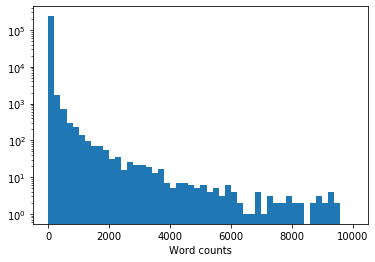

In [487]:
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [488]:
min_count = 5

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)#TODO<YOUR CODE HERE>

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens
print("Vocabulary size:", len(tokens))


Vocabulary size: 51660


In [489]:
token_to_id = dict(zip(tokens, [i for i in range(len(tokens))]))

In [490]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [491]:
print("Lines:")
print('\n'.join(data["title"][::10000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["title"][::10000]))

Lines:
jadon sancho • magical skills & goals
harry potter - all movies reviewed and ranked ( part 1 )
hermitcraft season 8 day 1 recap !
joe root ' s outstanding 100th test milestone | england cricket
devine mon personnage avant akinator ! ( c ' est le bordel )( ft . michou )

Matrix:
[[23371 38431 49777 27500 40227   200 19427     1     1     1     1     1
      1     1     1     1     1]
 [20627 34557   378  3918 30001 37089  4314 36037   224 32986   764   244
      1     1     1     1     1]
 [21046 38966  2437 12817   764 36301     2     1     1     1     1     1
      1     1     1     1     1]
 [23926 37684   201 38109 32499   792 43621 29109 49256 15762 12011     1
      1     1     1     1     1]
 [13562 29635 33541  5476  3726     2   224  8548   201 16155 25941  7521
    249 18364   515 28988   244]]


In [492]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

In [493]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  32093
Validation size =  8024


In [494]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["description", "title", 'tags']:
            batch_tensors[key] = torch.tensor(arr, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["title"] = as_matrix(data["title"].values, max_len)
    batch["description"] = as_matrix(data["description"].values, max_len)
    batch["tags"] = as_matrix(data["tags"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["description"] = apply_word_dropout(batch["description"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[target_column] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [495]:
target_column = 'Log1pViews'

In [496]:
batch = make_batch(data_train[:3], max_len=10)

In [497]:
emb = torch.nn.Embedding(len(tokens), 32) # конвертирует из интовых номеров слов/признаков в вектора; 
                                          # всего нужно сколько токенов, столько эмбеддингов;
                                          # размерность любая
linear = torch.nn.Linear(32, 1)

In [498]:
emb.weight

Parameter containing:
tensor([[ 0.0379,  1.3595, -0.6448,  ...,  1.2578,  0.4509, -0.8119],
        [-0.8291, -0.9384,  0.1207,  ...,  0.4257, -0.7259, -0.3924],
        [ 0.3024,  0.9295,  0.8222,  ..., -1.2171,  0.2468,  0.8176],
        ...,
        [ 1.1971, -0.2641, -0.0474,  ..., -2.1348,  0.1368, -0.4525],
        [ 0.7240,  1.0287, -0.3010,  ...,  0.7197,  1.3190, -0.0894],
        [ 1.2596, -0.8777, -1.3697,  ...,  0.6334,  0.6063,  0.4314]],
       requires_grad=True)

In [499]:
vectors = emb(batch['title']).mean(dim=1)

In [500]:
linear(vectors)

tensor([[-0.0824],
        [-0.0090],
        [-0.0706]], grad_fn=<AddmmBackward>)

In [501]:
np.random.seed(0)

In [502]:
import torch
import torch.nn as nn
import torch.functional as F

In [503]:
class ViewsPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings=n_tokens,
                                      embedding_dim=hid_size,
                                      padding_idx=0,
                                      max_norm=5.0)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=1,
                                              out_channels=100,
                                              kernel_size=(fs, hid_size)) for fs in [1, 2]])

        
        self.max_pool = nn.AdaptiveMaxPool1d(2)
        
        self.categories = nn.Linear(n_cat_features, 100)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(100 * 13, hid_size, bias=True)  
        self.fc2 = nn.Linear(hid_size, 1, bias=True) 
        
        
    def forward(self, batch):
        # emb
        x_embed_title = self.embedding(batch['title']).unsqueeze(1)
        x_embed_description = self.embedding(batch['description']).unsqueeze(1)
        x_embed_tags = self.embedding(batch['tags']).unsqueeze(1)
            
        # conv
        convolution_title = [conv(x_embed_title) for conv in self.convs]
        convolution_description = [conv(x_embed_description) for conv in self.convs]
        convolution_tags = [conv(x_embed_tags) for conv in self.convs]
       
        # pooling
        max_title = [self.max_pool(conv_title.squeeze().unsqueeze(2 if batch['title'].shape[0] != 1 else 0))
                     if len(conv_title.squeeze().shape) < 3 else self.max_pool(conv_title.squeeze())
                     for conv_title in convolution_title]
        
        title = torch.cat(max_title, dim=2)
        
        max_description = [self.max_pool(conv_description.squeeze().unsqueeze(2 if batch['description'].shape[0] != 1 else 0)) 
                     if len(conv_description.squeeze().shape) < 3 else self.max_pool(conv_description.squeeze())
                     for conv_description in convolution_description]
        
        description = torch.cat(max_description, dim=2) 
        
        max_tags = [self.max_pool(conv_tags.squeeze().unsqueeze(2 if batch['tags'].shape[0] != 1 else 0)) 
                     if len(conv_tags.squeeze().shape) < 3 else self.max_pool(conv_tags.squeeze())
                     for conv_tags in convolution_tags]
        
        tags = torch.cat(max_tags, dim=2) 
        
        # categories
        categories = self.categories(batch['Categorical']).unsqueeze(1).permute(0, 2, 1)
        
        #concat
        cat = torch.cat((title, description, tags, categories), dim=2)
#         cat = torch.cat((title, description, categories), dim=2)
        
        out = cat.view(cat.shape[0], -1)
#         print(out)
        
        out = self.fc1(self.relu(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out.reshape(-1)

In [504]:
model = ViewsPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

In [505]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=torch.device('cpu'), **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

In [506]:
import tqdm

BATCH_SIZE = 32
EPOCHS = 8
DEVICE = torch.device('cpu')

In [507]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
#             print('PRED', batch_pred)
#             print('FACT', batch[TARGET_COLUMN])
#             print(squared_error)
#             print(abs_error)
#             print(num_samples)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [ ]:
model = ViewsPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
#         print(pred)
        loss = criterion(pred, batch[TARGET_COLUMN])
#         print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val)


epoch: 0


  0%|          | 0/1002 [00:00<?, ?it/s]

 results:
Mean square error: 1.71753
Mean absolute error: 1.02401
epoch: 1


  0%|          | 0/1002 [00:00<?, ?it/s]

 results:
Mean square error: 2.47856
Mean absolute error: 1.29275
epoch: 2


  0%|          | 0/1002 [00:00<?, ?it/s]

 results:
Mean square error: 1.28680
Mean absolute error: 0.85842
epoch: 3


  0%|          | 0/1002 [00:00<?, ?it/s]

 results:
Mean square error: 1.18457
Mean absolute error: 0.82058
epoch: 4


  0%|          | 0/1002 [00:00<?, ?it/s]

In [412]:
model = ViewsPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
#         print(pred)
        loss = criterion(pred, batch[TARGET_COLUMN])
#         print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val)


epoch: 0


  0%|          | 0/2005 [00:00<?, ?it/s]

 results:
Mean square error: 1.50669
Mean absolute error: 0.93669
epoch: 1


  0%|          | 0/2005 [00:00<?, ?it/s]

 results:
Mean square error: 1.37666
Mean absolute error: 0.90377
epoch: 2


  0%|          | 0/2005 [00:00<?, ?it/s]

 results:
Mean square error: 1.73400
Mean absolute error: 1.00894
epoch: 3


  0%|          | 0/2005 [00:00<?, ?it/s]

 results:
Mean square error: 1.45512
Mean absolute error: 0.92232
epoch: 4


  0%|          | 0/2005 [00:00<?, ?it/s]

 results:
Mean square error: 1.15743
Mean absolute error: 0.81027


## Explain

In [413]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 
    
    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token)).detach().numpy()
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))

In [425]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
#         синий -- супер, красный -- не очень
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html

In [457]:
i = np.random.randint(len(data))
tokens_and_weights = explain(model, data.loc[i], "title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "description")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

tokens_and_weights = explain(model, data.loc[i], "tags")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

UNK UNK delrec lifesteal UNK

UNK montagne dv UNK UNK UNK UNK UNK lilyachty knopowcreated gianluca UNK closer UNK UNK logistics elevated closer coladangelo UNK UNK kut logistics UNK UNK UNK UNK UNK foxsoccer UNK UNK foxsoccer UNK gwszo5avp_dtagthuvfsssrrr UNK 300k UNK UNK moo kurama UNK UNK UNK UNK UNK UNK UNK glitter UNK UNK logistics UNK 452d9811 UNK closer hillary foxsoccer cawthon ebony lorax 452d9811 UNK 6mcsr65d9xc foxsoccer UNK UNK mings lanadelreyhttp logistics lifesteal UNK UNK 9 UNK UNK UNK UNK UNK UNK UNK UNK moo jackmasseywelshinstagram closer UNK UNK kickboxing 452d9811 lori UNK UNK UNK UNK

UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK favorites UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK ls1 UNK UNK ls1 UNK UNK eventually UNK fenty UNK maury jazzybum

In [ ]:
добавить категориальные признаки: наличие капслока, наличие ссылки в описании, время публикации (утро, день, вечер, ночь)